# Generative Models Part 1

In [ ]:
#!L
backend = 'Colab'
if backend == 'Colab':
    !git clone https://github.com/yandexdataschool/Practical_DL.git
    !sudo apt install -y ninja-build
    %cd /content/Practical_DL/week09_gans
    !wget https://www.dropbox.com/s/2kpsomtla61gjrn/pretrained.tar
    !tar -xvf pretrained.tar

In [1]:
#!L
%matplotlib inline

from tqdm.auto import tqdm, trange

import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt

from PIL import Image
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage, CenterCrop, ToTensor, Resize, GaussianBlur
from gans.gan_load import make_stylegan2, make_big_gan

torch.cuda.set_device(1)


def to_image(tensor, adaptive=False):
    if len(tensor.shape) == 4:
        tensor = tensor[0]
    if adaptive:
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    else:
        tensor = ((tensor + 1) / 2).clamp(0, 1)
    return ToPILImage()((255 * tensor.cpu().detach()).to(torch.uint8))


def to_image_grid(tensor, adaptive=False, **kwargs):
    return to_image(make_grid(tensor, **kwargs), adaptive)


def to_image_grid(tensor, adaptive=False, **kwargs):
    return to_image(make_grid(tensor, **kwargs), adaptive)

## LPIPS

https://richzhang.github.io/PerceptualSimilarity/

In [2]:
#!L
import lpips
lpips_dist = lpips.LPIPS('alexnet').cuda()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Cache file:/home/avoin/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
Loading model from: /home/avoin/anaconda3/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


/home/avoin/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


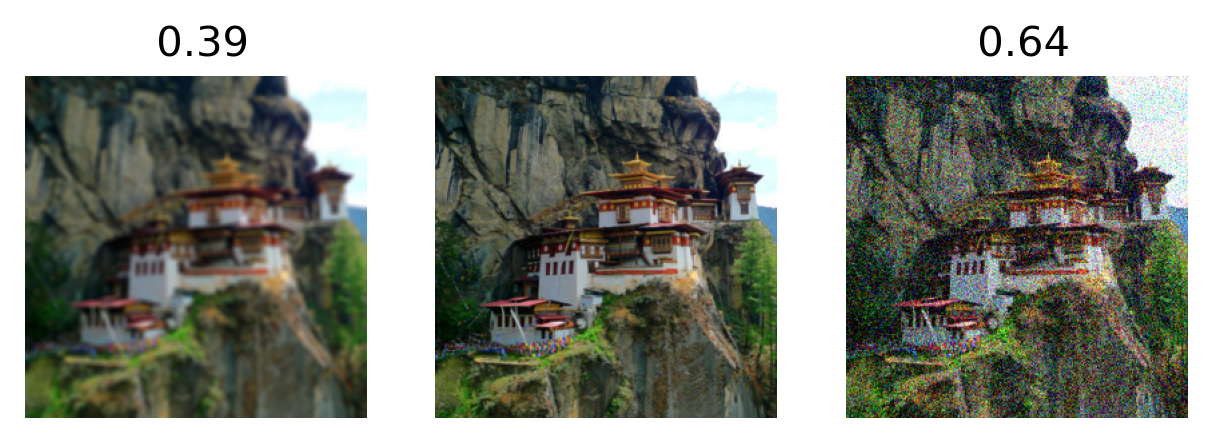

In [3]:
#!L
img = CenterCrop(256)(Resize(256)(Image.open('sample.png')))
ref_img = ToTensor()(img)[:3]
normalize = lambda x: 2 * x.unsqueeze(0) - 1

img_blured = normalize(ToTensor()(GaussianBlur(5, sigma=(2, 2))(img))[:3]).cuda()
ref_img = normalize(ref_img.cuda())
img_noised = ref_img + 0.3 * torch.randn_like(ref_img).cuda()


_, axs = plt.subplots(1, 3, dpi=250)
for ax in axs: ax.axis('off')
    
axs[0].imshow(to_image(img_blured))
axs[1].imshow(to_image(ref_img))
axs[2].imshow(to_image(img_noised))

axs[0].set_title(f'{lpips_dist(img_blured, ref_img).item(): 0.2f}');
axs[2].set_title(f'{lpips_dist(img_noised, ref_img).item(): 0.2f}');

## Deep Image Prior

https://dmitryulyanov.github.io/deep_image_prior

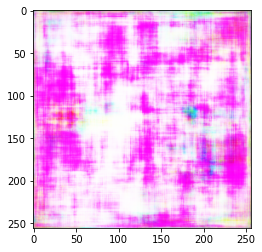

In [4]:
#!L
from resnet18_gen import make_resnet_generator, RES_GEN_CONFIGS


torch.manual_seed(0)
G_ref = make_resnet_generator(RES_GEN_CONFIGS[256])
G_ref.cuda().eval()

with torch.no_grad():
    z = torch.randn([1, G_ref.dim_z], device='cuda')
    img = G_ref(z)
    plt.imshow(to_image_grid(img))

In [6]:
#!L
from copy import deepcopy


def optimize_deep_image_prior(ref_img, lpips_weight: float, mask: torch.Tensor):
    n_steps = 2000

    G = deepcopy(G_ref)
    G.cuda().train()

    opt = torch.optim.Adam(G.parameters())
    mse = nn.MSELoss()

    for step in trange(n_steps):
        G.zero_grad()
        rec = G(z)

        rec_loss = (1.0 - lpips_weight) * mse(mask * rec, mask * ref_img) + \
                    lpips_weight * lpips_dist(mask * rec, mask * ref_img)
        rec_loss.backward()
        opt.step()

    return rec, G

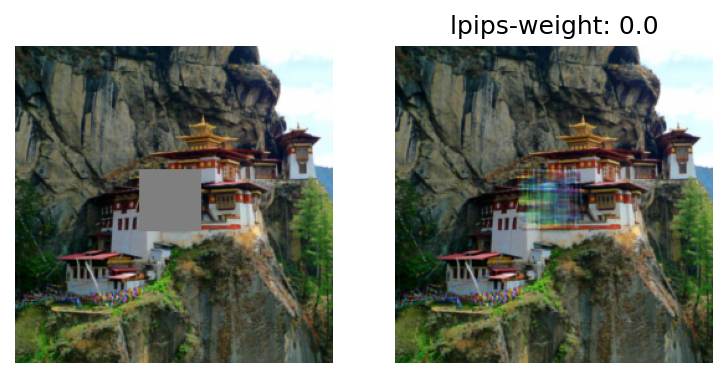

In [7]:
#!L
_, axs = plt.subplots(1, 2, dpi=150)
for ax in axs: ax.axis('off')

mask = torch.ones_like(ref_img)
mask[:, :, 100: 150, 100: 150] = 0.0
rec, G = optimize_deep_image_prior(ref_img, 0.0, mask)
 
plt.title('lpips-weight: 0.0')
axs[0].imshow(to_image(mask * rec, True))
axs[1].imshow(to_image(rec, True))

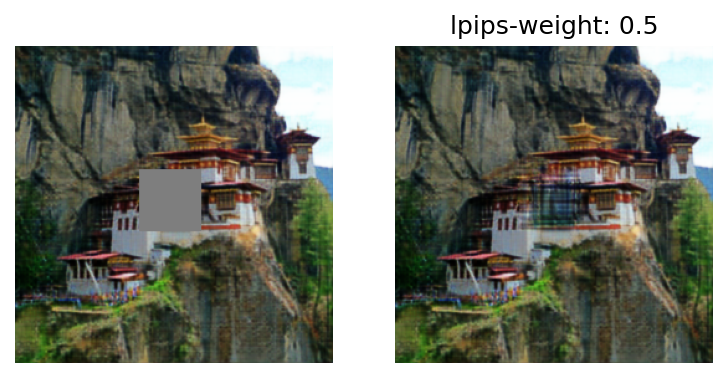

In [7]:
#!L
_, axs = plt.subplots(1, 2, dpi=150)
for ax in axs: ax.axis('off')

mask = torch.ones_like(ref_img)
mask[:, :, 100: 150, 100: 150] = 0.0
rec, G = optimize_deep_image_prior(ref_img, 0.5, mask)
 
plt.title('lpips-weight: 0.5')
axs[0].imshow(to_image(mask * rec, True))
axs[1].imshow(to_image(rec, True))

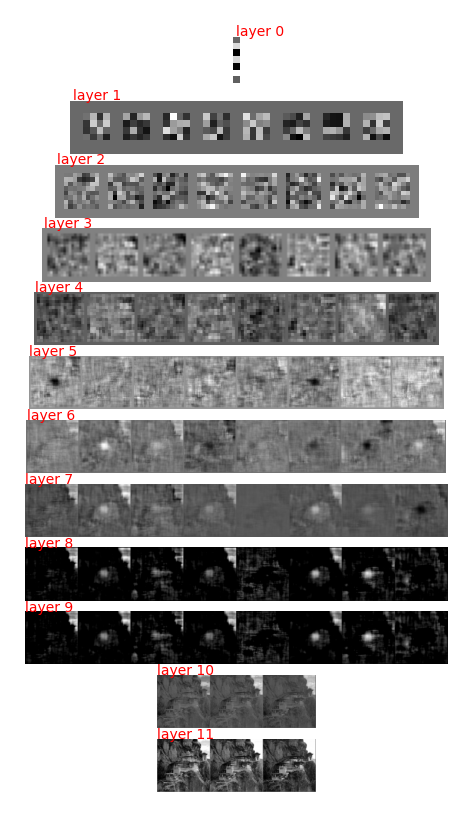

In [8]:
#!L
def activations_save_hook(self, input, out):
    setattr(self, 'activations', out)
    return out

hooks = []
for i in range(len(G)):
    hooks.append(G[i].register_forward_hook(activations_save_hook))

with torch.no_grad():
    G(z)

for h in hooks:
    h.remove()

# plot activations
for i, axs in enumerate(plt.subplots(len(G), 1, dpi=250)[1]):
    axs.axis('off')
    axs.text(0, -0.7, f'layer {i}', fontdict=dict(size=4, color='red'))
    axs.imshow(to_image_grid(G[i].activations[0, :8].unsqueeze(1), True))

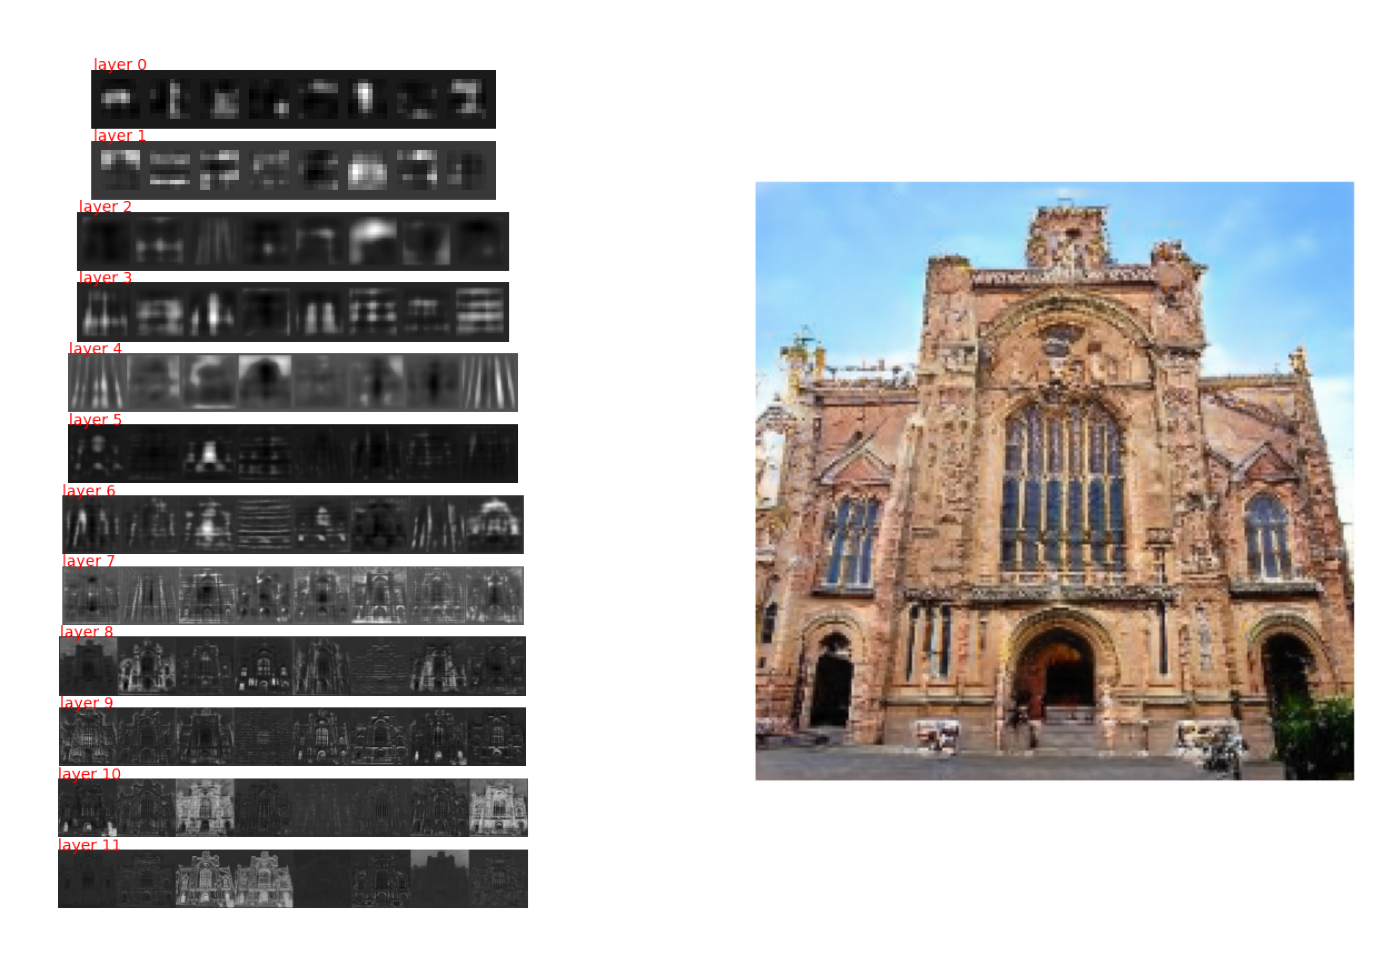

In [10]:
#!L
plt.figure(dpi=300)
plt.subplot(121)
plt.axis('off')
plt.imshow(Image.open('stylegan2_activations.png'))

plt.subplot(122)
plt.axis('off')
plt.imshow(Image.open('stylegan2_sample.png'))

# Conditional Generation

Adding attention layer in G at resolution 64


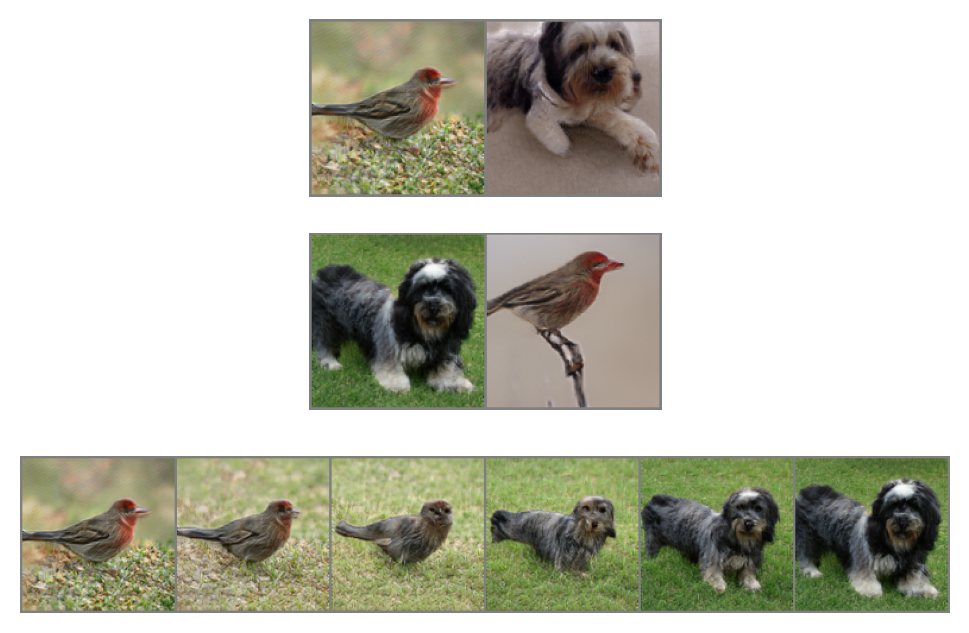

In [9]:
#!L
from scipy.stats import truncnorm
G = make_big_gan('pretrained/G_ema.pth', 128).cuda().eval()

with torch.no_grad():
    z = torch.randn([2, 512]).cuda()

    classes = nn.Parameter(torch.tensor([12, 200], dtype=torch.int64), requires_grad=False).cuda()
    cl_embed = G.big_gan.shared(classes)
    cl_embed_swap = torch.stack([cl_embed[1], cl_embed[0]])

    imgs = G.big_gan(z, cl_embed)
    imgs_cl_swap = G.big_gan(z, cl_embed_swap)

    interps = torch.arange(0, 1.01, 0.2).cuda()
    embeds = torch.stack([torch.lerp(cl_embed[0], cl_embed[1], a) for a in interps])

    imgs_cl_interp = G.big_gan(z[0][None].repeat(len(embeds), 1), embeds)
    
_, axs = plt.subplots(3, 1, dpi=200)
for ax in axs: ax.axis('off')

axs[0].imshow(to_image_grid(imgs))
axs[1].imshow(to_image_grid(imgs_cl_swap))
axs[2].imshow(to_image_grid(imgs_cl_interp))

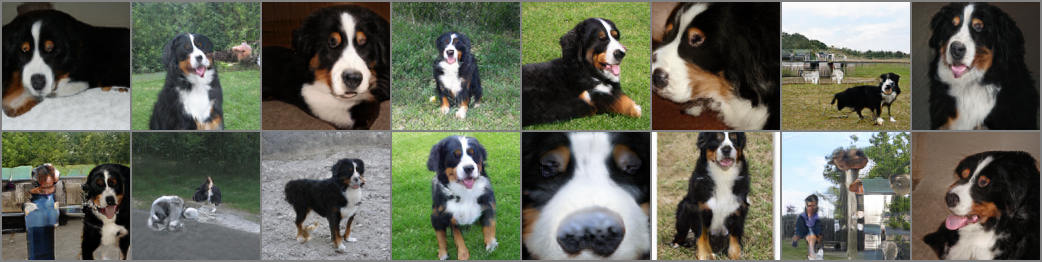

In [13]:
#!L
# truncation

batch = 16
truncation = 10

with torch.no_grad():
    tr = truncnorm(-truncation, truncation)
    z = torch.from_numpy(tr.rvs(batch * 512)).view([batch, 512]).float().cuda()

    cl_embed = G.big_gan.shared(torch.tensor(batch * [239], dtype=torch.int64).cuda())
    imgs = G.big_gan(z, cl_embed)

to_image_grid(imgs)

# Unconditional Generaion and Latent Directions

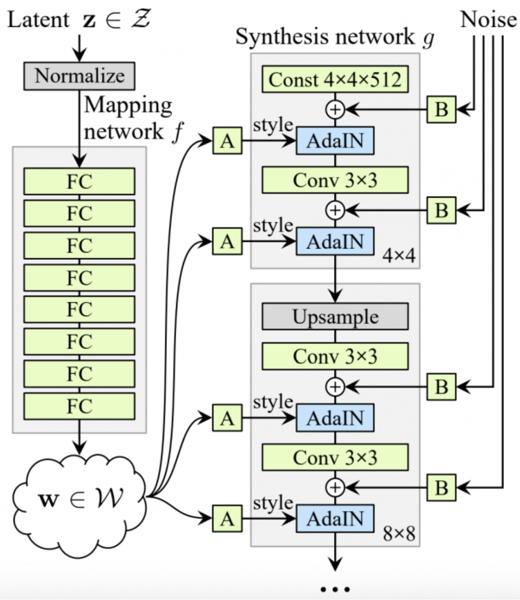

In [15]:
Image.open('stylegan.png').resize([520, 600])

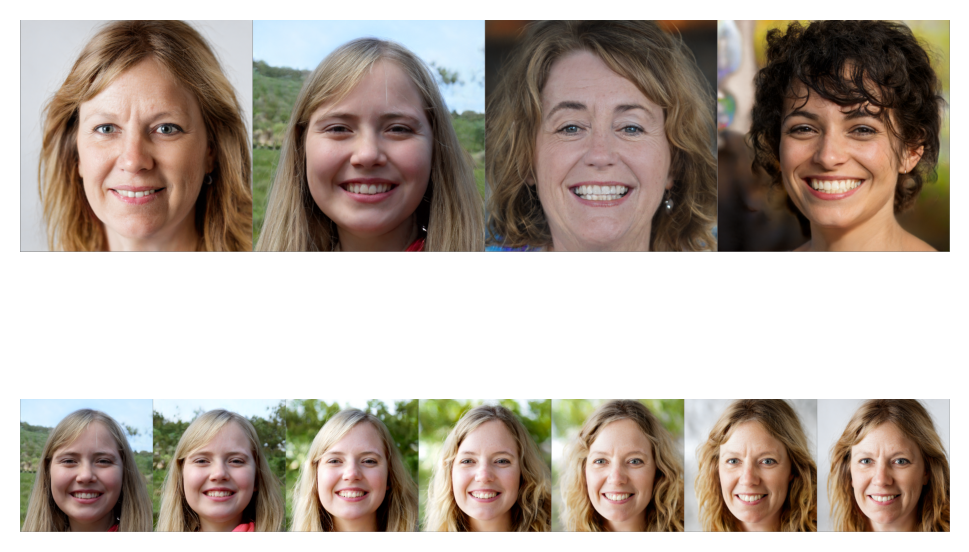

In [16]:
#!L
G = make_stylegan2(resolution=1024,
                   weights='pretrained/stylegan2-ffhq-config-f.pt').eval()


with torch.no_grad():
    z = torch.randn([4, 512]).cuda()
    imgs = G(z)

    z = torch.stack([a * z[0] + (1 - a) * z[1] for a in torch.arange(0, 1.01, 0.15)])
    imgs_interp = G(z)

_, axs = plt.subplots(2, 1, dpi=200)
for ax in axs: ax.axis('off')

axs[0].imshow(to_image_grid(imgs, nrow=6))
axs[1].imshow(to_image_grid(imgs_interp, nrow=len(z)))

# Latent Manipulations

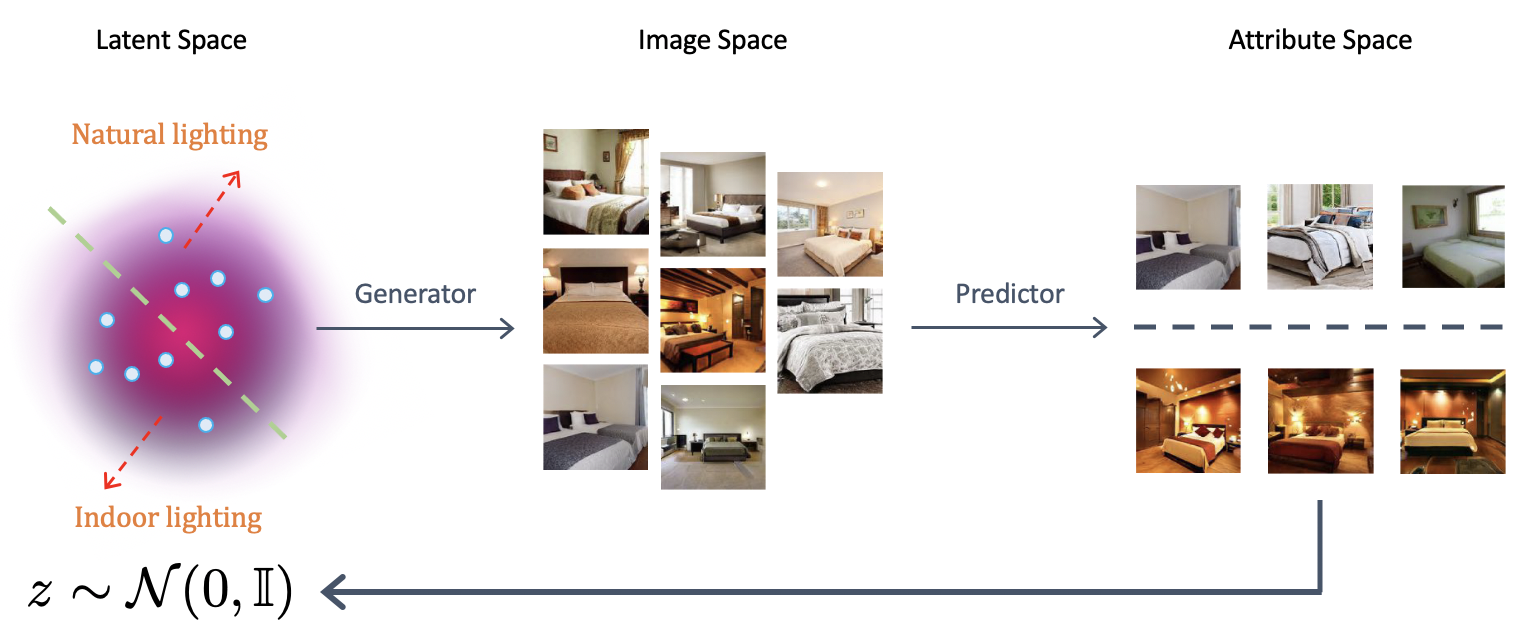

In [18]:
Image.open('infogan.png')

In [17]:
#!L
from supervised_deformation_finder.model import CelebaAttributeClassifier
from supervised_deformation_finder.utils import \
    prepare_generator_output_for_celeba_regressor as preprocess


print('- Attributes -\n')
with open('supervised_deformation_finder/celeba_attributes.txt') as f:
    attributes = f.readline().split(' ')
    attributes.sort()
    for i, att in enumerate(attributes):
        if i % 4 != 0:
            print(att.ljust(22), end='')
        else:
            print(att)

- Attributes -

5_o_Clock_Shadow
Arched_Eyebrows       Attractive            Bags_Under_Eyes       Bald
Bangs                 Big_Lips              Big_Nose              Black_Hair
Blond_Hair            Blurry                Brown_Hair            Bushy_Eyebrows
Chubby                Double_Chin           Eyeglasses            Goatee
Gray_Hair             Heavy_Makeup          High_Cheekbones       Male
Mouth_Slightly_Open   Mustache              Narrow_Eyes           No_Beard
Oval_Face             Pale_Skin             Pointy_Nose           Receding_Hairline
Rosy_Cheeks           Sideburns             Smiling               Straight_Hair
Wavy_Hair             Wearing_Earrings      Wearing_Hat           Wearing_Lipstick
Wearing_Necklace      Wearing_Necktie       Young                 

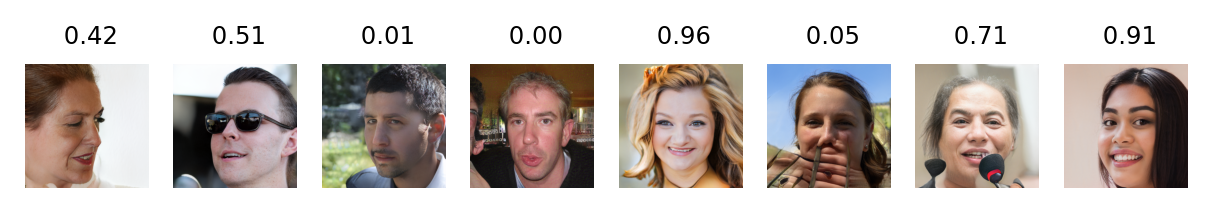

In [26]:
#!L
from dataclasses import dataclass
from sklearn.svm import LinearSVR


@dataclass
class ShiftedGSample:
    latent: list = None
    val: float = None


def train_normal(samples, svm_max_iter=10_000):
    num_samples = len(samples)
    latents = torch.stack([s.latent for s in samples])
    expectations = torch.tensor([s.val for s in samples])

    # estimate attribute direction
    print(f'Starting SVM training with {num_samples} samples')
    svm = LinearSVR(max_iter=svm_max_iter)
    svm.fit(latents, expectations)
    normal = torch.from_numpy(svm.coef_).to(torch.float).cuda()

    return normal


# accumulate statistics

regressor = CelebaAttributeClassifier('Smiling', 'pretrained/regressor.pth').cuda().eval()

num_steps, batch = 200, 8
samples = []
for latents in tqdm(torch.randn([num_steps, batch, 512])):
    with torch.no_grad():
        latents = G.style_gan2.style(latents.cuda())
        imgs = G(latents, w_space=True)
        probs = regressor.get_probs(preprocess(imgs))[:, 1]
    samples += [ShiftedGSample(l, p) for l, p in zip(latents.cpu(), probs.cpu())]

for i, ax in enumerate(plt.subplots(1, len(imgs), dpi=250)[1]):
    ax.axis('off')
    ax.set_title(f'{probs[i].item(): 0.2f}', fontdict=dict(size=7))
    ax.imshow(to_image(imgs[i]))

In [27]:
#!L
shift = train_normal(samples, 600)

Starting SVM training with 1600 samples


/home/avoin/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


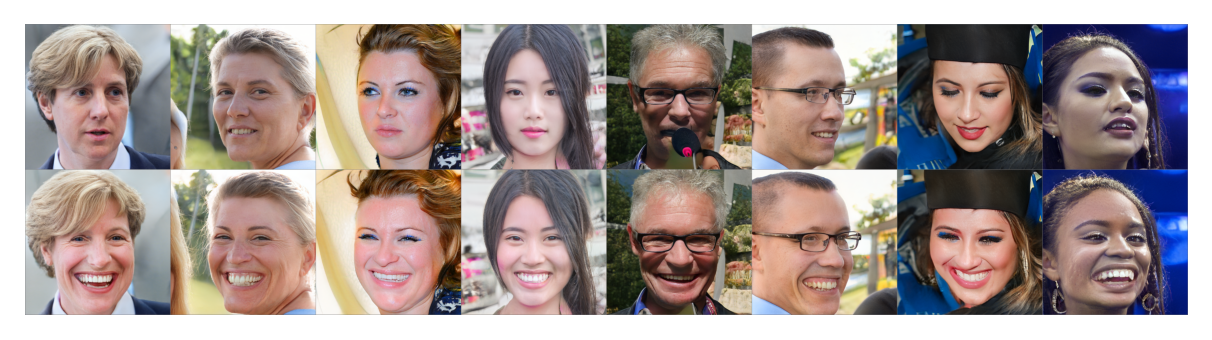

In [29]:
#L
with torch.no_grad():
    z = torch.randn([8, 512]).cuda()
    imgs_orig = G(z)
    
    w = G.style_gan2.style(z)
    imgs_shifted = G(w + 5 * shift, w_space=True)

plt.figure(dpi=250)
plt.axis('off')
plt.imshow(to_image_grid(torch.cat([imgs_orig, imgs_shifted]), nrow=len(imgs_orig)))